## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [1]:
import os
import keras
import matplotlib.pyplot as plt
%matplotlib inline


# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [9]:

def build_mlp(input_shape,neural = [512,256,128], out_num = 10):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)

    for i, n_neural in enumerate(neural):
        if i == 0:
            x = keras.layers.Dense(units=n_neural, activation='relu', name= f"hidden_layer_{i+1}")(input_layer)
            x = keras.layers.BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_neural, activation='relu', name= f"hidden_layer_{i+1}")(x)
            x = keras.layers.BatchNormalization()(x)

    output = keras.layers.Dense(units=out_num, activation='softmax', name = "output_category")(x)

    model = keras.models.Model(inputs=input_layer, outputs=output)

    return model

In [7]:
"""Code Here
設定超參數
"""

LEARNING_RATE = 0.001
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [14]:
# 載入 Callbacks
"""Code Here
設定 callbacks: Earlystop
"""
from keras.callbacks import EarlyStopping

earlystop_30 = EarlyStopping(monitor = 'val_loss', patience=30, verbose=1)
earlystop_loss = EarlyStopping(monitor = 'val_loss', patience=5, verbose=1)
earlystop_acc = EarlyStopping(monitor = 'val_accuracy', patience=5, verbose=1)

results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
mtd = ['30_at_least','loss','acc']
for i, stop_monitor in enumerate([earlystop_30,earlystop_loss,earlystop_acc]):

    keras.backend.clear_session()

    print(f"---- stop_monitor_{mtd[i]} ----")
    model = build_mlp(input_shape = x_train.shape[1:])
    optimizers = keras.optimizers.Adam(lr= LEARNING_RATE)
    model.compile(loss= 'categorical_crossentropy',metrics=['accuracy'], optimizer= optimizers)
    model.fit(x_train, y_train, epochs=EPOCHS, batch_size= BATCH_SIZE, validation_data= (x_test,y_test), shuffle=True, callbacks= [stop_monitor])

    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]

    name_tag = f"stop_monitor_{mtd[i]}"
    results[name_tag] = {'train-loss': train_loss,
                        'valid-loss': valid_loss,
                        'train-acc': train_acc,
                        'valid-acc': valid_acc}

---- stop_monitor_30_at_least ----
Epoch 1/50
49/49 [==============================] - 8s 166ms/step - loss: 1.7796 - accuracy: 0.3833 - val_loss: 2.2922 - val_accuracy: 0.2180
Epoch 2/50
49/49 [==============================] - 8s 161ms/step - loss: 1.4980 - accuracy: 0.4734 - val_loss: 2.0145 - val_accuracy: 0.3031
Epoch 3/50
49/49 [==============================] - 8s 162ms/step - loss: 1.3939 - accuracy: 0.5097 - val_loss: 1.9207 - val_accuracy: 0.3219
Epoch 4/50
49/49 [==============================] - 8s 162ms/step - loss: 1.3177 - accuracy: 0.5355 - val_loss: 1.8362 - val_accuracy: 0.3565
Epoch 5/50
49/49 [==============================] - 8s 161ms/step - loss: 1.2448 - accuracy: 0.5654 - val_loss: 1.7178 - val_accuracy: 0.3885
Epoch 6/50
49/49 [==============================] - 8s 161ms/step - loss: 1.1921 - accuracy: 0.5812 - val_loss: 1.7670 - val_accuracy: 0.3770
Epoch 7/50
49/49 [==============================] - 8s 162ms/step - loss: 1.1396 - accuracy: 0.6017 - val_loss: 1

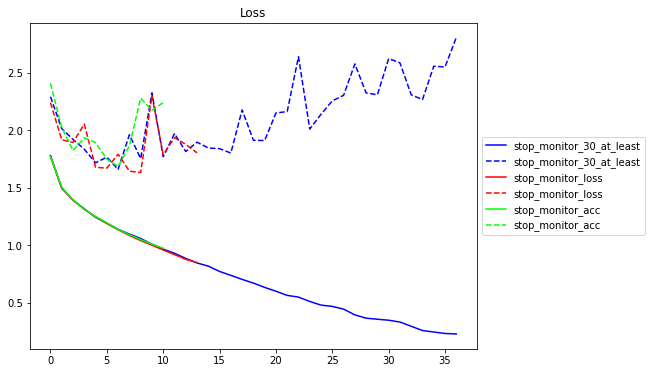

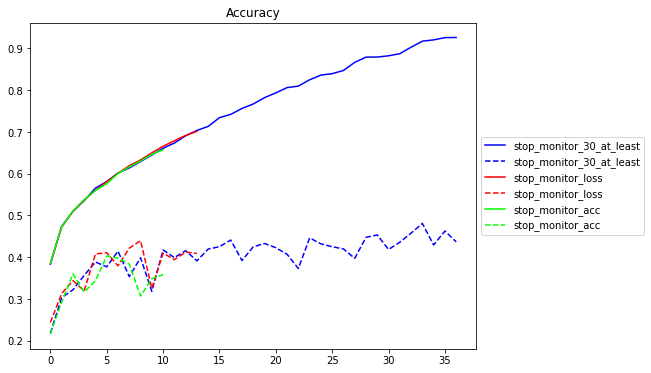

In [27]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = 3

cm = plt.get_cmap('brg')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()